# ICL 20/21 - ML Algorithm Fairness Coursework

### Setup

In [ ]:
!pip install 'aif360[LFR]'

In [ ]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/compas/

In [ ]:
!wget https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv

In [ ]:
#Import the libraries and set the random seed.

import numpy as np
import math
import copy

from aif360.datasets import CompasDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_compas

from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing

import pdb

from sklearn.preprocessing import StandardScaler  #MinMaxScaler
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import *

SEED = 0
np.random.seed(SEED)

In [ ]:
#We define where's the bias in the features of our dataset.
privileged_groups = [{'race': 1, 'sex':1}]
unprivileged_groups = [{'race': 0, 'sex':0}]
dataset_orig = load_preproc_data_compas(['sex','race'])

#We split between training and test set.
train, test = dataset_orig.split([0.9], shuffle=True)

# split the train set into 10 folds for cross-validation
folds = 10
folds_data = train.split(folds) # list of 10 sub-sets of type Dataset (not np)

scale_orig = StandardScaler()
scaler = scale_orig.fit(train.features) # fit a scaler on all the train data

# get the test data ready for later
X_test = scaler.transform(test.features)
y_test = test.labels.ravel()

### Task 1

#### Logistic regression: CV

In [ ]:
# Actual cross-validation

C_params = [1e-15, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6,
            1e-5,1e-4, 1e-3,1e-2, 1e-1, 1, 1e2, 1e5, 1e10,] 
metric_arrs = dict()

for c in C_params:
    metric_arrs[str(c)] = dict()
    metric_arrs[str(c)]['acc'] = []
    metric_arrs[str(c)]['bal_acc'] = []
    metric_arrs[str(c)]['disp_imp'] = []
    metric_arrs[str(c)]['stat_par_diff'] = []
    metric_arrs[str(c)]['eq_opp_diff'] = []
    metric_arrs[str(c)]['avg_odds_diff'] = []

    for i in range(folds):
        # set aside a validation fold
        val = folds_data[i]
        labels_val = folds_data[i].labels.ravel()

        # concatenate the remaining folds to get the train set
        to_concat = folds_data[:i] + folds_data[i+1 :]
        concat_labels = [data.labels.ravel() for data in to_concat]
        to_concat = [scaler.transform(data.features) for data in to_concat]

        train_np = np.concatenate(to_concat, axis=0)
        train_labels = np.concatenate(concat_labels)

        # fit the model
        learner = LogisticRegression(solver='liblinear', random_state=SEED, C=c) 
        learner.fit(train_np, train_labels)

        # make predictions on the validation set and save tem as Dataset labels
        predictions = learner.predict(scaler.transform(val.features))
        val_pred = val.copy()
        val_pred.labels = predictions

        metric_arrs[str(c)]['acc'].append(sum(predictions==labels_val)/len(labels_val))

        metric = ClassificationMetric(val, val_pred, 
                                    unprivileged_groups = unprivileged_groups, 
                                    privileged_groups = privileged_groups)
        #Balanced accuracy
        metric_arrs[str(c)]['bal_acc'].append(((metric.true_positive_rate() + metric.true_negative_rate()) / 2))

        #Disparate Impact (closer to 1 better, close to 0 strong bias)
        metric_arrs[str(c)]['disp_imp'].append((metric.disparate_impact()))

        #Statistical Parity Difference (closer to 0 better)
        metric_arrs[str(c)]['stat_par_diff'].append((metric.statistical_parity_difference()))

        #Equal opportunity difference (closer to 0 better, if <0 bias tw priviledged)
        metric_arrs[str(c)]['eq_opp_diff'].append((metric.equal_opportunity_difference()))

        #Average of difference in FPR and TPR for unprivileged and privileged groups. 
        metric_arrs[str(c)]['avg_odds_diff'].append((metric.average_odds_difference()))

In [ ]:
cv_results = dict()

for key in metric_arrs.keys():
    cv_results[key] = dict()
    for key_2 in metric_arrs[key].keys():
        cv_results[key][key_2] = sum(metric_arrs[key][key_2])/len(metric_arrs[key][key_2])

for key in cv_results.keys():
    print('{:.2e}'.format(float(key)), cv_results[key])

1.00e-15 {'acc': 0.6532631578947368, 'bal_acc': 0.652264749960556, 'disp_imp': 0.33037357832926983, 'stat_par_diff': -0.6092313600065478, 'eq_opp_diff': -0.5226765684846878, 'avg_odds_diff': -0.5725957098370681}
1.00e-10 {'acc': 0.6532631578947368, 'bal_acc': 0.652264749960556, 'disp_imp': 0.33037357832926983, 'stat_par_diff': -0.6092313600065478, 'eq_opp_diff': -0.5226765684846878, 'avg_odds_diff': -0.5725957098370681}
1.00e-09 {'acc': 0.6532631578947368, 'bal_acc': 0.652264749960556, 'disp_imp': 0.33037357832926983, 'stat_par_diff': -0.6092313600065478, 'eq_opp_diff': -0.5226765684846878, 'avg_odds_diff': -0.5725957098370681}
1.00e-08 {'acc': 0.6532631578947368, 'bal_acc': 0.652264749960556, 'disp_imp': 0.33037357832926983, 'stat_par_diff': -0.6092313600065478, 'eq_opp_diff': -0.5226765684846878, 'avg_odds_diff': -0.5725957098370681}
1.00e-07 {'acc': 0.6532631578947368, 'bal_acc': 0.652264749960556, 'disp_imp': 0.33037357832926983, 'stat_par_diff': -0.6092313600065478, 'eq_opp_diff':

In [ ]:
acc = []
bal_acc = []
disp_imp = []
stat_par = []
eq_op = []
avg_odds = []

for key in cv_results.keys():
    acc.append(cv_results[key]['acc'])
    bal_acc.append(cv_results[key]['bal_acc'])
    disp_imp.append(cv_results[key]['disp_imp'])
    stat_par.append(cv_results[key]['stat_par_diff'])
    eq_op.append(cv_results[key]['eq_opp_diff'])
    avg_odds.append(cv_results[key]['avg_odds_diff'])

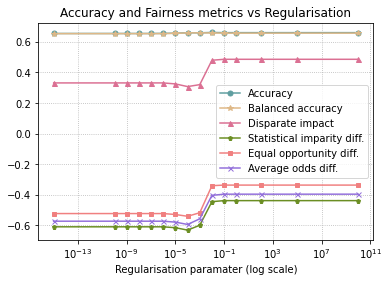

In [ ]:
import matplotlib.pyplot as plt

plt.plot(C_params, acc, color='cadetblue', marker = "o", markersize=5, label = "Accuracy")
plt.plot(C_params, bal_acc, color = 'burlywood', marker = "*",markersize=6, label = "Balanced accuracy")
plt.plot(C_params, disp_imp, color= 'palevioletred', marker ="^", markersize=5, label = "Disparate impact")
plt.plot(C_params, stat_par, color = 'olivedrab', marker = "p", markersize=5, label = "Statistical imparity diff.")
plt.plot(C_params, eq_op, color = 'lightcoral', marker = "s", markersize=4, label = "Equal opportunity diff.")
plt.plot(C_params, avg_odds,color='mediumpurple', marker = "x", markersize=5, label = "Average odds diff.")
plt.grid(True, which="major", linestyle="dotted")
plt.legend()
plt.xscale("log")
plt.xlabel("Regularisation paramater (log scale)")
plt.title("Accuracy and Fairness metrics vs Regularisation")
plt.show()

#### Final model evaluation

In [ ]:
# Evaluating final model

metric_arrs = dict()
final_cs = [1e-1, 1e-2]

for c in final_cs:
    for seed in range(5):
        SEED = seed
        np.random.seed(SEED)

        metric_arrs[str(c)] = dict()
        metric_arrs[str(c)]['acc'] = []
        metric_arrs[str(c)]['bal_acc'] = []
        metric_arrs[str(c)]['disp_imp'] = []
        metric_arrs[str(c)]['stat_par_diff'] = []
        metric_arrs[str(c)]['eq_opp_diff'] = []
        metric_arrs[str(c)]['avg_odds_diff'] = []
        
        train_labels = train.labels.ravel()
        train_np = scaler.transform(train.features)

        # fit the model
        learner = LogisticRegression(solver='liblinear', random_state=SEED, C=c) 
        learner.fit(train_np, train_labels)

        # make predictions on the validation set and save tem as Dataset labels
        predictions = learner.predict(X_test)
        test_pred = test.copy()
        test_pred.labels = predictions

        metric_arrs[str(c)]['acc'].append(sum(predictions==test.labels.ravel())/len(test.labels.ravel()))

        metric = ClassificationMetric(test, test_pred, 
                                    unprivileged_groups = unprivileged_groups, 
                                    privileged_groups = privileged_groups)
        #Balanced accuracy
        metric_arrs[str(c)]['bal_acc'].append(((metric.true_positive_rate() + metric.true_negative_rate()) / 2))

        #Disparate Impact (closer to 1 better, close to 0 strong bias)
        metric_arrs[str(c)]['disp_imp'].append((metric.disparate_impact()))

        #Statistical Parity Difference (closer to 0 better)
        metric_arrs[str(c)]['stat_par_diff'].append((metric.statistical_parity_difference()))

        #Equal opportunity difference (closer to 0 better, if <0 bias tw priviledged)
        metric_arrs[str(c)]['eq_opp_diff'].append((metric.equal_opportunity_difference()))

        #Average of difference in FPR and TPR for unprivileged and privileged groups. 
        metric_arrs[str(c)]['avg_odds_diff'].append((metric.average_odds_difference()))

In [ ]:
cv_results = dict()

for key in metric_arrs.keys():
    cv_results[key] = dict()
    for key_2 in metric_arrs[key].keys():
        cv_results[key][key_2] = sum(metric_arrs[key][key_2])/len(metric_arrs[key][key_2])

for key in cv_results.keys():
    print('{:.2e}'.format(float(key)), cv_results[key])

1.00e-01 {'acc': 0.6515151515151515, 'bal_acc': 0.6427421810431075, 'disp_imp': 0.5546834118262689, 'stat_par_diff': -0.35289239062823974, 'eq_opp_diff': -0.2712053571428571, 'avg_odds_diff': -0.31376359811165844}
1.00e-02 {'acc': 0.6496212121212122, 'bal_acc': 0.6402409848188264, 'disp_imp': 0.5177045177045176, 'stat_par_diff': -0.4094961642131454, 'eq_opp_diff': -0.2997767857142857, 'avg_odds_diff': -0.38360486795292825}


In [ ]:
# set seed back to what it was originally
SEED = 0

### Task 2

#### Logistic regression: CV

In [ ]:
# Actual cross-validation

C_params = [1e-15, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 
            1e-3,1e-2, 1e-1, 1, 1e2, 1e3, 1e4, 1e5, 1e7,1e8,1e9, 1e10, 1e15] 
f_metric_arrs = dict()

RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

reweights = RW.fit(train)

for c in C_params:
    f_metric_arrs[str(c)] = dict()
    f_metric_arrs[str(c)]['acc'] = []
    f_metric_arrs[str(c)]['bal_acc'] = []
    f_metric_arrs[str(c)]['disp_imp'] = []
    f_metric_arrs[str(c)]['stat_par_diff'] = []
    f_metric_arrs[str(c)]['eq_opp_diff'] = []
    f_metric_arrs[str(c)]['avg_odds_diff'] = []

    for i in range(folds):
        # set aside a validation fold
        val = folds_data[i]
        labels_val = folds_data[i].labels.ravel()

        # concatenate the remaining folds to get the train set
        to_concat = folds_data[:i] + folds_data[i+1 :]
        concat_labels = [data.labels.ravel() for data in to_concat]
        w_to_concat = [(reweights.transform(data)).instance_weights for data in to_concat]
        to_concat = [scaler.transform(data.features) for data in to_concat]

        train_np = np.concatenate(to_concat, axis=0)
        train_weights = np.concatenate(w_to_concat, axis=0)
        train_labels = np.concatenate(concat_labels)

        # fit the model
        learner = LogisticRegression(solver='liblinear', random_state=SEED, C=c) 
        learner.fit(train_np, train_labels, sample_weight=train_weights)

        # make predictions on the validation set and save tem as Dataset labels
        predictions = learner.predict(scaler.transform(val.features))
        val_pred = val.copy()
        val_pred.labels = predictions

        f_metric_arrs[str(c)]['acc'].append(sum(predictions==labels_val)/len(labels_val))

        metric = ClassificationMetric(val, val_pred, 
                                    unprivileged_groups = unprivileged_groups, 
                                    privileged_groups = privileged_groups)
        #Balanced accuracy
        f_metric_arrs[str(c)]['bal_acc'].append(((metric.true_positive_rate() + metric.true_negative_rate()) / 2))

        #Disparate Impact (closer to 1 better, close to 0 strong bias)
        f_metric_arrs[str(c)]['disp_imp'].append((metric.disparate_impact()))

        #Statistical Parity Difference (closer to 0 better)
        f_metric_arrs[str(c)]['stat_par_diff'].append((metric.statistical_parity_difference()))

        #Equal opportunity difference (closer to 0 better, if <0 bias tw priviledged)
        f_metric_arrs[str(c)]['eq_opp_diff'].append((metric.equal_opportunity_difference()))

        #Average of difference in FPR and TPR for unprivileged and privileged groups. 
        f_metric_arrs[str(c)]['avg_odds_diff'].append((metric.average_odds_difference()))

In [ ]:
f_cv_results = dict()

for key in f_metric_arrs.keys():
    f_cv_results[key] = dict()
    for key_2 in f_metric_arrs[key].keys():
        f_cv_results[key][key_2] = sum(f_metric_arrs[key][key_2])/len(f_metric_arrs[key][key_2])

for key in f_cv_results.keys():
    print('{:.2e}'.format(float(key)), f_cv_results[key])

1.00e-15 {'acc': 0.6524210526315789, 'bal_acc': 0.6490750948641464, 'disp_imp': 0.48603265228258064, 'stat_par_diff': -0.42139742444033723, 'eq_opp_diff': -0.3407108394805306, 'avg_odds_diff': -0.37586668033563586}
1.00e-10 {'acc': 0.6524210526315789, 'bal_acc': 0.6490750948641464, 'disp_imp': 0.48603265228258064, 'stat_par_diff': -0.42139742444033723, 'eq_opp_diff': -0.3407108394805306, 'avg_odds_diff': -0.37586668033563586}
1.00e-09 {'acc': 0.6524210526315789, 'bal_acc': 0.6490750948641464, 'disp_imp': 0.48603265228258064, 'stat_par_diff': -0.42139742444033723, 'eq_opp_diff': -0.3407108394805306, 'avg_odds_diff': -0.37586668033563586}
1.00e-08 {'acc': 0.6524210526315789, 'bal_acc': 0.6490750948641464, 'disp_imp': 0.48603265228258064, 'stat_par_diff': -0.42139742444033723, 'eq_opp_diff': -0.3407108394805306, 'avg_odds_diff': -0.37586668033563586}
1.00e-07 {'acc': 0.6524210526315789, 'bal_acc': 0.6490750948641464, 'disp_imp': 0.48603265228258064, 'stat_par_diff': -0.42139742444033723, 

In [ ]:
r_acc = []
r_bal_acc = []
r_disp_imp = []
r_stat_par = []
r_eq_op = []
r_avg_odds = []

for key in f_cv_results.keys():
    r_acc.append(f_cv_results[key]['acc'])
    r_bal_acc.append(f_cv_results[key]['bal_acc'])
    r_disp_imp.append(f_cv_results[key]['disp_imp'])
    r_stat_par.append(f_cv_results[key]['stat_par_diff'])
    r_eq_op.append(f_cv_results[key]['eq_opp_diff'])
    r_avg_odds.append(f_cv_results[key]['avg_odds_diff'])

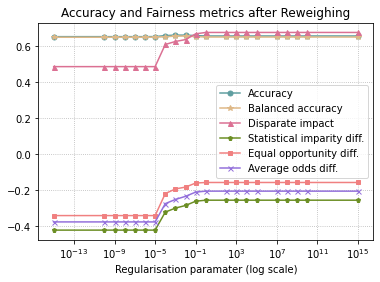

In [ ]:
import matplotlib.pyplot as plt

plt.plot(C_params, r_acc, color='cadetblue', marker = "o", markersize=5, label = "Accuracy")
plt.plot(C_params, r_bal_acc, color = 'burlywood', marker = "*",markersize=6, label = "Balanced accuracy")
plt.plot(C_params, r_disp_imp, color= 'palevioletred', marker ="^", markersize=5, label = "Disparate impact")
plt.plot(C_params, r_stat_par, color = 'olivedrab', marker = "p", markersize=5, label = "Statistical imparity diff.")
plt.plot(C_params, r_eq_op, color = 'lightcoral', marker = "s", markersize=4, label = "Equal opportunity diff.")
plt.plot(C_params, r_avg_odds,color='mediumpurple', marker = "x", markersize=5, label = "Average odds diff.")
plt.grid(True, which="major", linestyle="dotted")
plt.legend()
plt.xscale("log")
plt.xlabel("Regularisation paramater (log scale)")
plt.title("Accuracy and Fairness metrics after Reweighing")
plt.show()

#### Final model evaluation

In [ ]:
# Final model evaluation

C_params = [1e-3, 1] 
f_metric_arrs = dict()

RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

reweights = RW.fit_transform(train)

for c in C_params:
    f_metric_arrs[str(c)] = dict()
    f_metric_arrs[str(c)]['acc'] = []
    f_metric_arrs[str(c)]['bal_acc'] = []
    f_metric_arrs[str(c)]['disp_imp'] = []
    f_metric_arrs[str(c)]['stat_par_diff'] = []
    f_metric_arrs[str(c)]['eq_opp_diff'] = []
    f_metric_arrs[str(c)]['avg_odds_diff'] = []
    for SEED in range(5):

        train_labels = train.labels.ravel()
        train_np = scaler.transform(train.features)

        # fit the model
        learner = LogisticRegression(solver='liblinear', random_state=SEED, C=c) 
        learner.fit(train_np, train_labels, sample_weight = reweights.instance_weights)

        # make predictions on the validation set and save tem as Dataset labels
        predictions = learner.predict(X_test)
        test_pred = test.copy()
        test_pred.labels = predictions

        f_metric_arrs[str(c)]['acc'].append(sum(predictions==test.labels.ravel())/len(test.labels.ravel()))

        metric = ClassificationMetric(test, test_pred, 
                                    unprivileged_groups = unprivileged_groups, 
                                    privileged_groups = privileged_groups)
        #Balanced accuracy
        f_metric_arrs[str(c)]['bal_acc'].append(((metric.true_positive_rate() + metric.true_negative_rate()) / 2))

        #Disparate Impact (closer to 1 better, close to 0 strong bias)
        f_metric_arrs[str(c)]['disp_imp'].append((metric.disparate_impact()))

        #Statistical Parity Difference (closer to 0 better)
        f_metric_arrs[str(c)]['stat_par_diff'].append((metric.statistical_parity_difference()))

        #Equal opportunity difference (closer to 0 better, if <0 bias tw priviledged)
        f_metric_arrs[str(c)]['eq_opp_diff'].append((metric.equal_opportunity_difference()))

        #Average of difference in FPR and TPR for unprivileged and privileged groups. 
        f_metric_arrs[str(c)]['avg_odds_diff'].append((metric.average_odds_difference()))

In [ ]:
cv_results = dict()

for key in f_metric_arrs.keys():
    cv_results[key] = dict()
    for key_2 in f_metric_arrs[key].keys():
        cv_results[key][key_2] = sum(f_metric_arrs[key][key_2])/len(f_metric_arrs[key][key_2])

for key in cv_results.keys():
    print('{:.2e}'.format(float(key)), cv_results[key])

# for key in f_metric_arrs.keys():
#     for key_2 in f_metric_arrs[key].keys():
#         print(key)
#         print(f_metric_arrs[key][key_2])

1.00e-03 {'acc': 0.6590909090909091, 'bal_acc': 0.6457001174474749, 'disp_imp': 0.647130647130647, 'stat_par_diff': -0.2796323173681665, 'eq_opp_diff': -0.1696428571428571, 'avg_odds_diff': -0.23884441707717566}
1.00e+00 {'acc': 0.6647727272727273, 'bal_acc': 0.6524207229544565, 'disp_imp': 0.6629143214509067, 'stat_par_diff': -0.26076439283986463, 'eq_opp_diff': -0.1696428571428571, 'avg_odds_diff': -0.21106663929939792}


In [ ]:
SEED = 0

### Task 3

In [ ]:
C_params = [1e-15, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3,1e-2, 1e-1, 1, 1e2, 1e3, 1e4, 1e5, 1e7,1e8,1e9, 1e10, 1e15] 
metric_arrs = dict()
f_metric_arrs = dict()

for c in C_params:
    f_metric_arrs[str(c)] = dict()
    f_metric_arrs[str(c)]['acc'] = []
    f_metric_arrs[str(c)]['bal_acc'] = []
    f_metric_arrs[str(c)]['disp_imp'] = []
    f_metric_arrs[str(c)]['stat_par_diff'] = []
    f_metric_arrs[str(c)]['eq_opp_diff'] = []
    f_metric_arrs[str(c)]['avg_odds_diff'] = []
    
    metric_arrs[str(c)] = dict()
    metric_arrs[str(c)]['acc'] = []
    metric_arrs[str(c)]['bal_acc'] = []
    metric_arrs[str(c)]['disp_imp'] = []
    metric_arrs[str(c)]['stat_par_diff'] = []
    metric_arrs[str(c)]['eq_opp_diff'] = []
    metric_arrs[str(c)]['avg_odds_diff'] = []
    for SEED in range(5):

        np.random.seed(SEED)
        #We split between training and test set.
        train, test = dataset_orig.split([0.9], shuffle=True)

        scale_orig = StandardScaler()
        scaler = scale_orig.fit(train.features) # fit a scaler on all the train data

        # get the test data ready for later
        X_test = scaler.transform(test.features)
        y_test = test.labels.ravel()

        train_labels = train.labels.ravel()
        train_np = scaler.transform(train.features)

        ##### REGULARISATION FINAL EVAL HERE #####


        # fit the model
        learner = LogisticRegression(solver='liblinear', random_state=SEED, C=c) 
        learner.fit(train_np, train_labels)

        # make predictions on the validation set and save tem as Dataset labels
        predictions = learner.predict(X_test)
        test_pred = test.copy()
        test_pred.labels = predictions

        metric_arrs[str(c)]['acc'].append(sum(predictions==test.labels.ravel())/len(test.labels.ravel()))

        metric = ClassificationMetric(test, test_pred, 
                                    unprivileged_groups = unprivileged_groups, 
                                    privileged_groups = privileged_groups)
        #Balanced accuracy
        metric_arrs[str(c)]['bal_acc'].append(((metric.true_positive_rate() + metric.true_negative_rate()) / 2))

        #Disparate Impact (closer to 1 better, close to 0 strong bias)
        metric_arrs[str(c)]['disp_imp'].append((metric.disparate_impact()))

        #Statistical Parity Difference (closer to 0 better)
        metric_arrs[str(c)]['stat_par_diff'].append((metric.statistical_parity_difference()))

        #Equal opportunity difference (closer to 0 better, if <0 bias tw priviledged)
        metric_arrs[str(c)]['eq_opp_diff'].append((metric.equal_opportunity_difference()))

        #Average of difference in FPR and TPR for unprivileged and privileged groups. 
        metric_arrs[str(c)]['avg_odds_diff'].append((metric.average_odds_difference()))

        ##### REWEIGHING FINAL EVAL HERE #####

        RW = Reweighing(unprivileged_groups=unprivileged_groups,
                        privileged_groups=privileged_groups)

        reweights = RW.fit_transform(train)

        # fit the model
        f_learner = LogisticRegression(solver='liblinear', random_state=SEED, C=c) 
        f_learner.fit(train_np, train_labels, sample_weight = reweights.instance_weights)

        # make predictions on the validation set and save tem as Dataset labels
        predictions = f_learner.predict(X_test)
        test_pred = test.copy()
        test_pred.labels = predictions

        f_metric_arrs[str(c)]['acc'].append(sum(predictions==test.labels.ravel())/len(test.labels.ravel()))

        metric = ClassificationMetric(test, test_pred, 
                                    unprivileged_groups = unprivileged_groups, 
                                    privileged_groups = privileged_groups)
        #Balanced accuracy
        f_metric_arrs[str(c)]['bal_acc'].append(((metric.true_positive_rate() + metric.true_negative_rate()) / 2))

        #Disparate Impact (closer to 1 better, close to 0 strong bias)
        f_metric_arrs[str(c)]['disp_imp'].append((metric.disparate_impact()))

        #Statistical Parity Difference (closer to 0 better)
        f_metric_arrs[str(c)]['stat_par_diff'].append((metric.statistical_parity_difference()))

        #Equal opportunity difference (closer to 0 better, if <0 bias tw priviledged)
        f_metric_arrs[str(c)]['eq_opp_diff'].append((metric.equal_opportunity_difference()))

        #Average of difference in FPR and TPR for unprivileged and privileged groups. 
        f_metric_arrs[str(c)]['avg_odds_diff'].append((metric.average_odds_difference()))

In [ ]:
import statistics

cv_results = dict()
f_cv_results = dict()

f_cv_results['avg'] = dict()
cv_results['avg'] = dict()
f_cv_results['std'] = dict()
cv_results['std'] = dict()

for key in f_metric_arrs.keys():
    f_cv_results['avg'][key] = dict()
    f_cv_results['std'][key] = dict()
    for key2 in f_metric_arrs[key].keys():
        f_cv_results['avg'][key][key2] = sum(f_metric_arrs[key][key2])/len(f_metric_arrs[key][key2])
        f_cv_results['std'][key][key2] = statistics.stdev(f_metric_arrs[key][key2])

for key in f_metric_arrs.keys():
    cv_results['avg'][key] = dict()
    cv_results['std'][key] = dict()
    for key2 in f_metric_arrs[key].keys():
        cv_results['avg'][key][key2] = sum(metric_arrs[key][key2])/len(metric_arrs[key][key2])
        cv_results['std'][key][key2] = statistics.stdev(metric_arrs[key][key2])

for key in cv_results.keys():
    for key2 in cv_results[key].keys():
        print(key, key2, cv_results[key][key2])

print("\n")

for key in f_cv_results.keys():
    for key2 in f_cv_results[key].keys():
        print(key, key2, f_cv_results[key][key2])

avg 1e-15 {'acc': 0.6439393939393939, 'bal_acc': 0.6410483674102242, 'disp_imp': 0.4098207251123108, 'stat_par_diff': -0.5363965424208399, 'eq_opp_diff': -0.47583386036978126, 'avg_odds_diff': -0.5110848211116321}
avg 1e-10 {'acc': 0.6439393939393939, 'bal_acc': 0.6410483674102242, 'disp_imp': 0.4098207251123108, 'stat_par_diff': -0.5363965424208399, 'eq_opp_diff': -0.47583386036978126, 'avg_odds_diff': -0.5110848211116321}
avg 1e-09 {'acc': 0.6439393939393939, 'bal_acc': 0.6410483674102242, 'disp_imp': 0.4098207251123108, 'stat_par_diff': -0.5363965424208399, 'eq_opp_diff': -0.47583386036978126, 'avg_odds_diff': -0.5110848211116321}
avg 1e-08 {'acc': 0.6439393939393939, 'bal_acc': 0.6410483674102242, 'disp_imp': 0.4098207251123108, 'stat_par_diff': -0.5363965424208399, 'eq_opp_diff': -0.47583386036978126, 'avg_odds_diff': -0.5110848211116321}
avg 1e-07 {'acc': 0.6439393939393939, 'bal_acc': 0.6410483674102242, 'disp_imp': 0.4098207251123108, 'stat_par_diff': -0.5363965424208399, 'eq_o